In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [35]:
SPLIT_DATE_TRAIN = "2020-01-01"
RADIUS = 300
THRESHOLD = 400 

In [36]:
df = pd.read_csv("../data/with_features_more_features_all.csv")
df.isna().sum()

time              0
longitude         0
latitude          0
depth             0
mag               0
longitude_disc    0
latitude_disc     0
pos               0
lat_cent          0
lon_cent          0
plate_region      0
dist_region       0
dist              0
plate             0
label             0
dtype: int64

In [37]:
df

,time,longitude,latitude,depth,mag,longitude_disc,latitude_disc,pos,lat_cent,lon_cent,plate_region,dist_region,dist,plate,label
0,1973-01-02,-155.204333,19.326000,6.589000,2.21,-156,19,19_-156,19.5,-155.5,22,3527.668174,3521.228924,22.0,0
1,1973-01-02,-155.253167,19.314833,7.041000,1.93,-156,19,19_-156,19.5,-155.5,22,3527.668174,3525.575831,22.0,0
2,1973-01-03,-155.290167,19.399833,7.864000,1.76,-156,19,19_-156,19.5,-155.5,22,3527.668174,3521.146991,22.0,0
3,1973-01-03,-155.273667,19.408500,13.166000,1.94,-156,19,19_-156,19.5,-155.5,22,3527.668174,3519.272394,22.0,0
4,1973-01-03,-155.575000,19.181833,7.752000,3.56,-156,19,19_-156,19.5,-155.5,22,3527.668174,3559.168484,22.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098071,2023-06-13,-118.192100,4.470200,10.000000,4.60,-119,4,4_-119,4.5,-118.5,14,1633.352399,1601.473896,14.0,1
4098072,2023-08-21,-98.293874,30.624390,2.885661,2.40,-99,30,30_-99,30.5,-98.5,31,1226.082818,1250.068257,31.0,1
4098073,2023-08-29,159.673400,-43.490800,10.000000,4.10,159,-44,-44_159,-43.5,159.5,7,550.481875,540.143436,7.0,1
4098074,2023-08-29,159.717700,-43.367800,10.000000,4.30,159,-44,-44_159,-43.5,159.5,7,550.481875,546.066482,7.0,1


In [38]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [39]:
def filter_regions(df: pd.DataFrame, threshold: int, radious: int) -> pd.DataFrame:
    df_f = df[df["time"] <= SPLIT_DATE_TRAIN]
    regions = []
    lens = []
    for pos in tqdm.tqdm(df_f["pos"].unique()):
        # tmp = df_f.copy(deep=True)
        lat, lon = pos.split("_")
        lat, lon = float(lat), float(lon)
        diff = int(radious / 111) + 3
        tmp = df_f[(df_f["latitude"] >= lat - diff) & (df_f["latitude"] <= lat + diff) & (df_f["longitude"] >= lon - diff) & (df_f["longitude"] <= lon + diff)]
        tmp["distance"] = haversine_distance(tmp["latitude"], tmp["longitude"], lat + 0.5, lon + 0.5)
        tmp = tmp[tmp["distance"] <= radious]
        if len(tmp) >= threshold:
            regions.append(pos)
    return regions

In [40]:
regions = filter_regions(df, THRESHOLD, RADIUS)
df = df[df["pos"].isin(regions)]

100%|██████████| 9299/9299 [05:55<00:00, 26.18it/s]


<Axes: xlabel='time'>

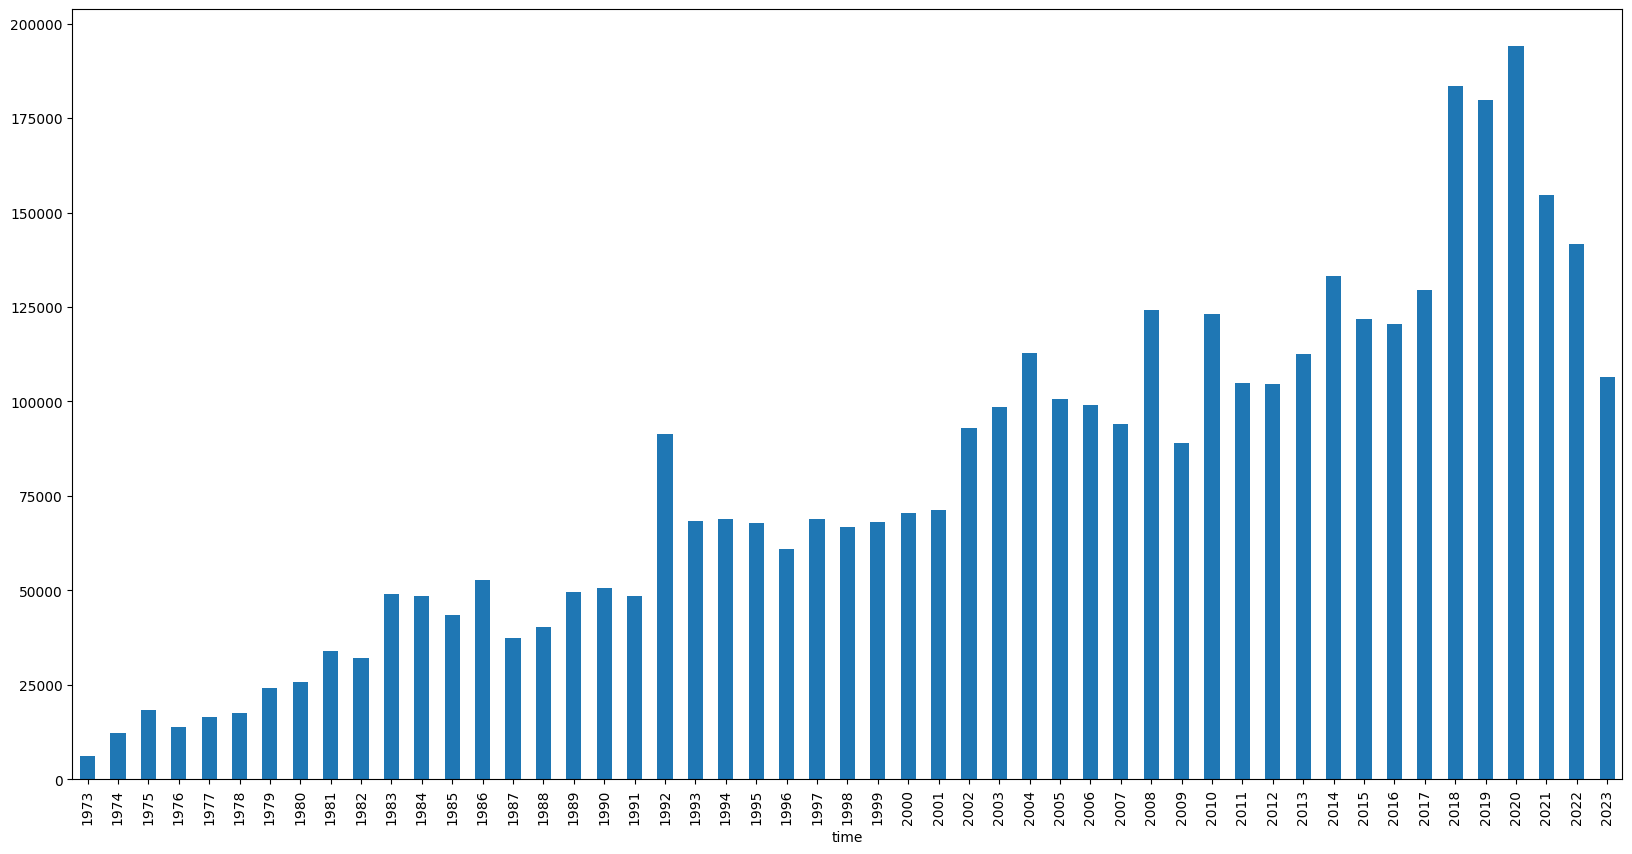

In [41]:
# plot count of earthquakes over time on barplot
df["time"] = df["time"].apply(lambda x: x[:4])
df["time"].value_counts().sort_index().plot.bar(figsize=(20, 10))

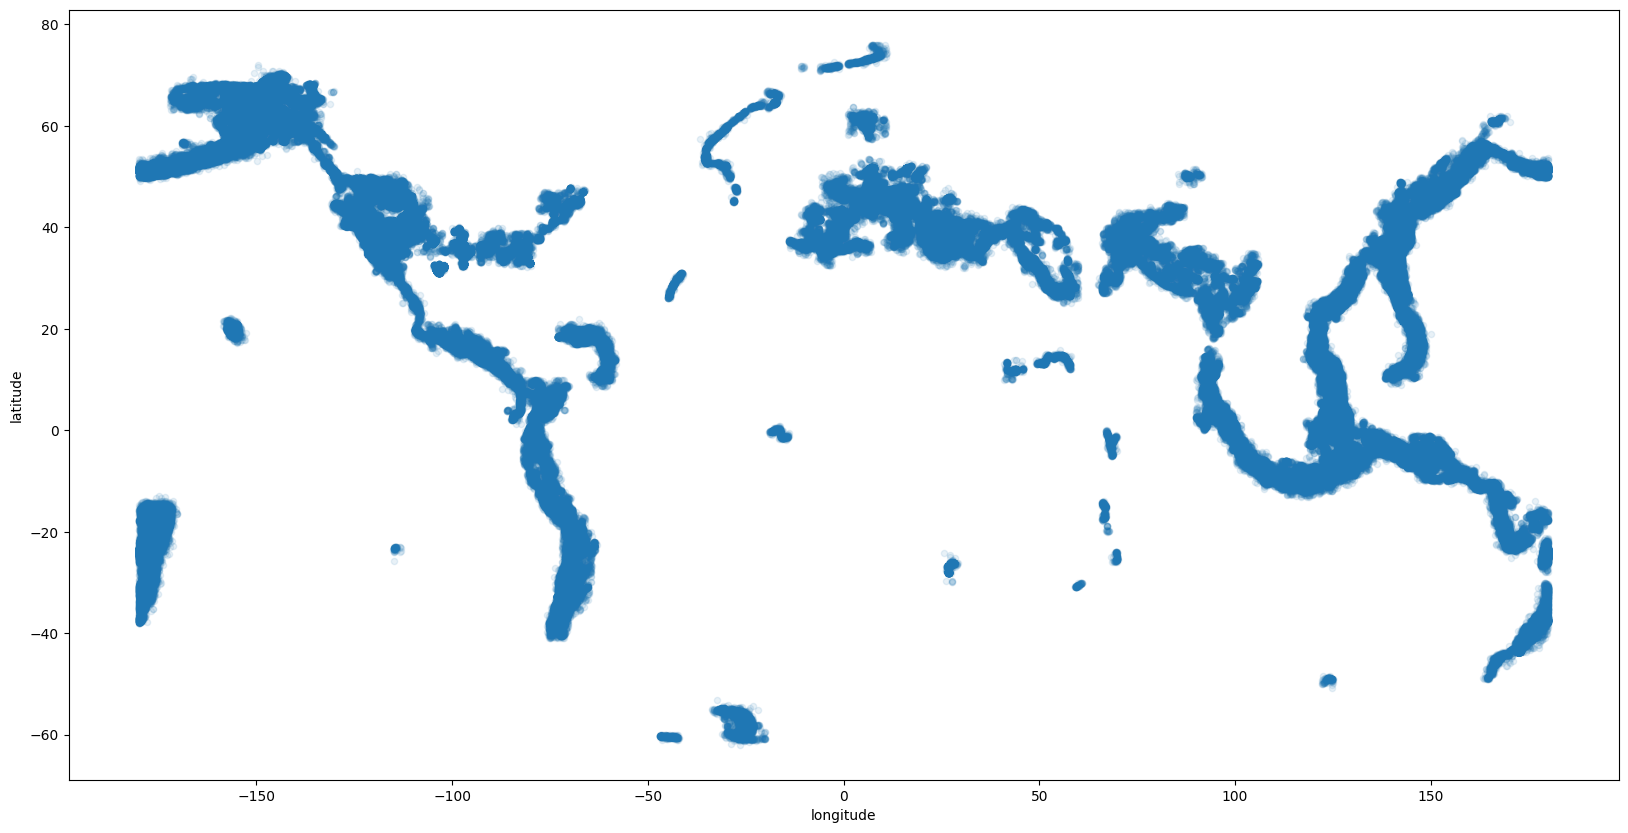

In [42]:
# plot count of earthquakes over longitude and latitude
df.plot.scatter(x="longitude", y="latitude", alpha=0.1, figsize=(20, 10))
plt.show()

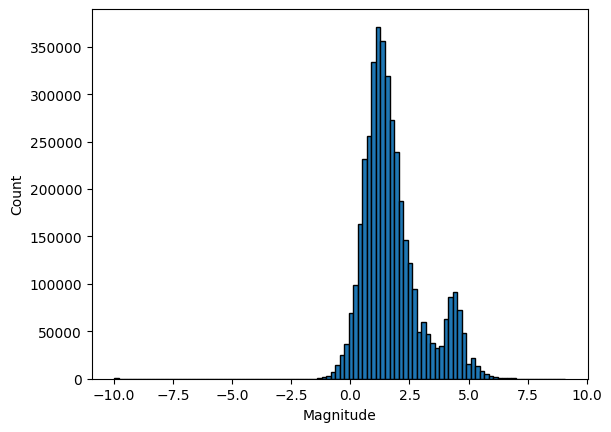

In [43]:
# plot magnitude
df["mag"].plot.hist(bins=100, edgecolor="black")
plt.ylabel("Count")
plt.xlabel("Magnitude")
plt.show()

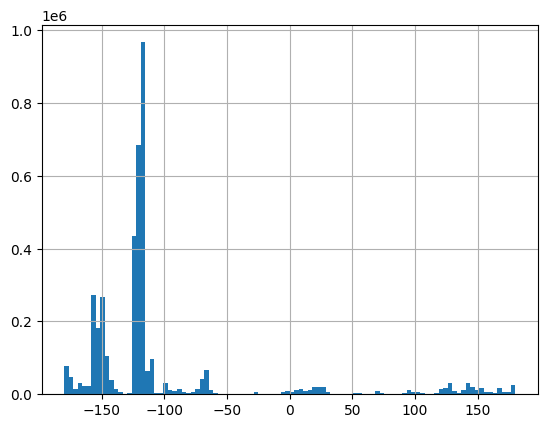

In [44]:
# plot count of earthquakes over longitude
df["longitude"].hist(bins=100)
plt.show()

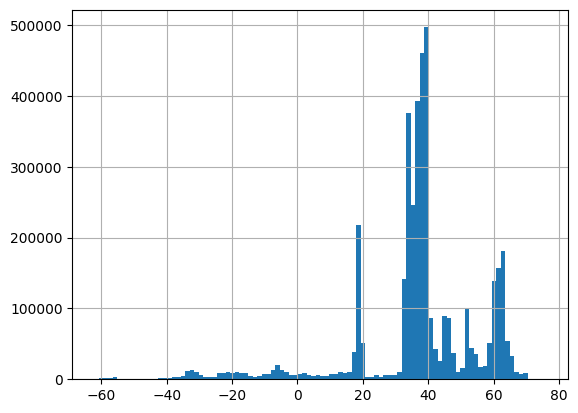

In [45]:
# plot count of earthquakes over latitude
df["latitude"].hist(bins=100)
plt.show()

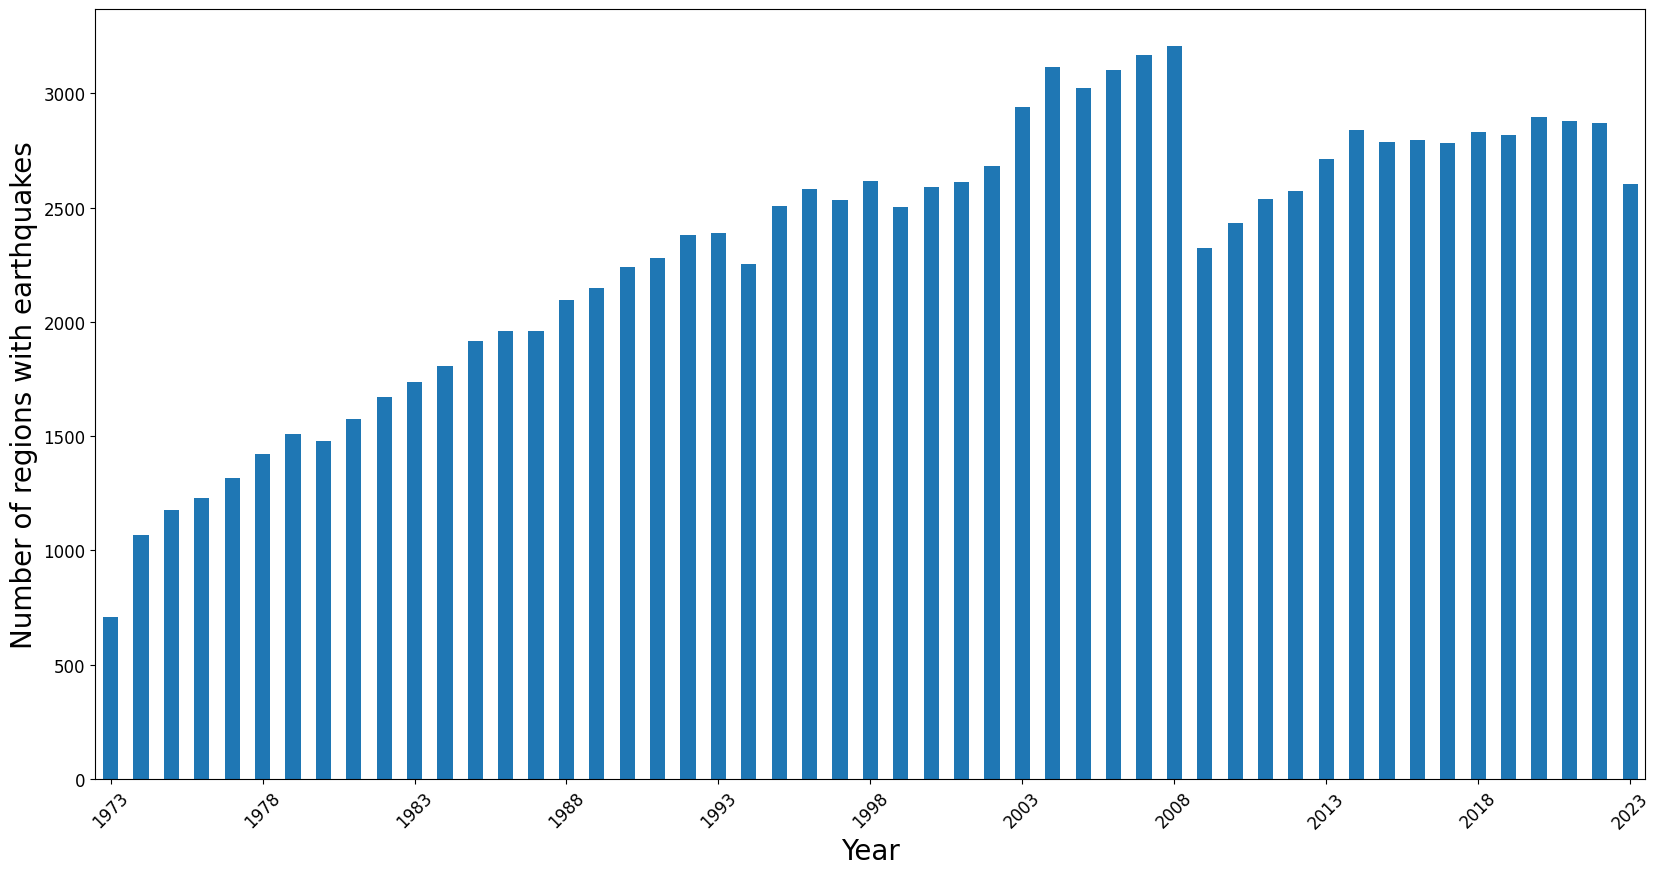

In [46]:
# get number of regions with eq per year
df.groupby(["time", "pos"]).count().reset_index().groupby("time").agg({"mag": "count"}).plot.bar(figsize=(20, 10), legend=False)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of regions with earthquakes", fontsize=20)
plt.xticks(np.arange(0, len(df["time"].unique()), 5), df["time"].unique()[::5], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<Axes: xlabel='time'>

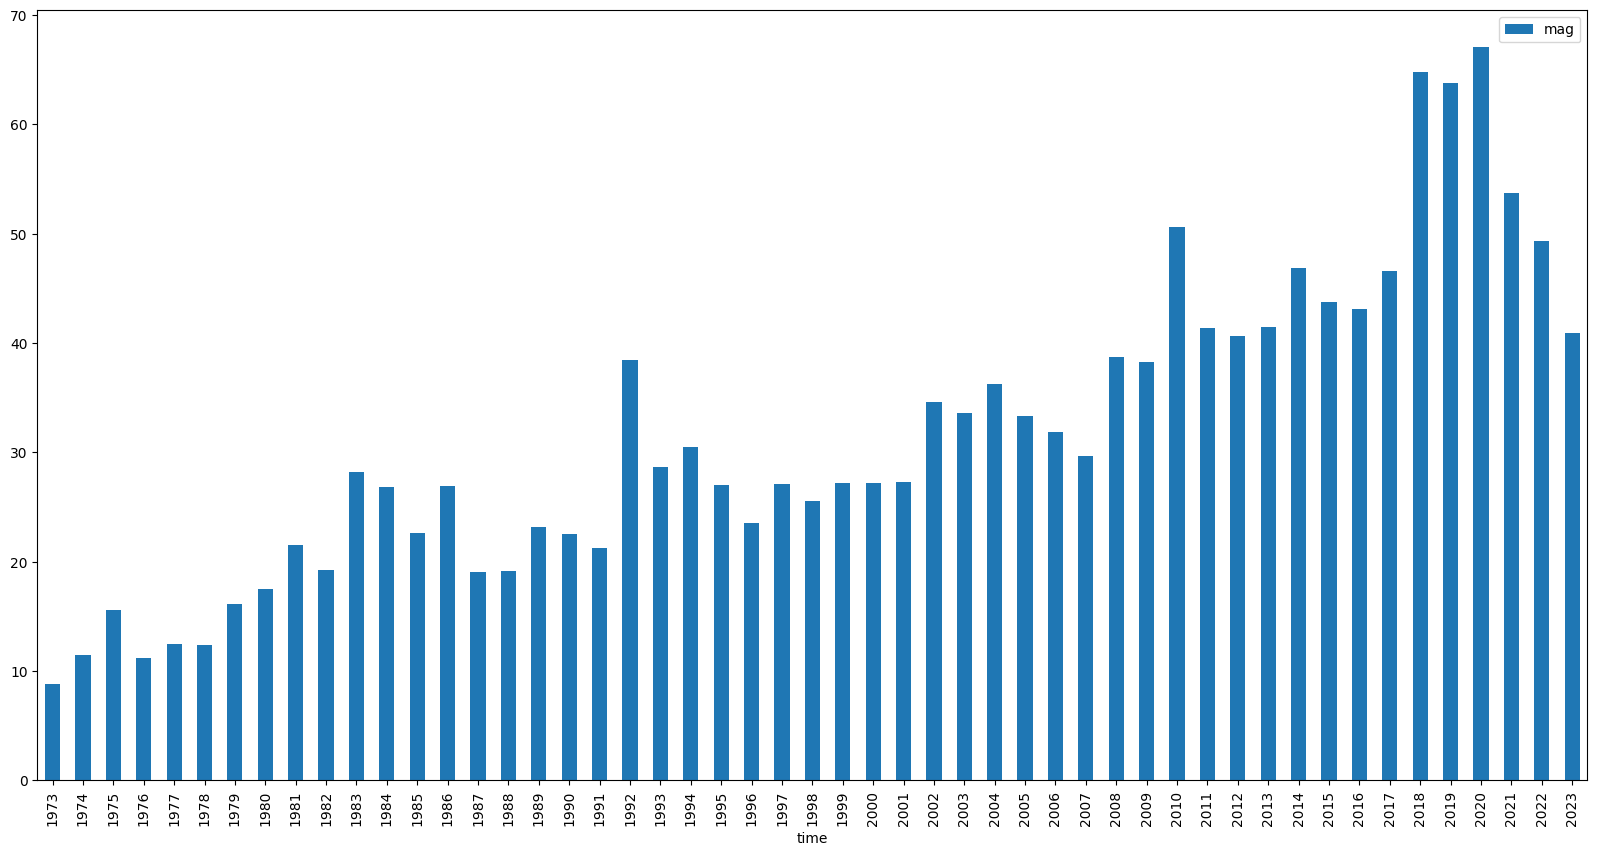

In [47]:
# get average number of earthquakes per region per year
df.groupby(["time", "pos"]).count().reset_index().groupby("time").agg({"mag": "mean"}).plot.bar(figsize=(20, 10))

<Axes: xlabel='time'>

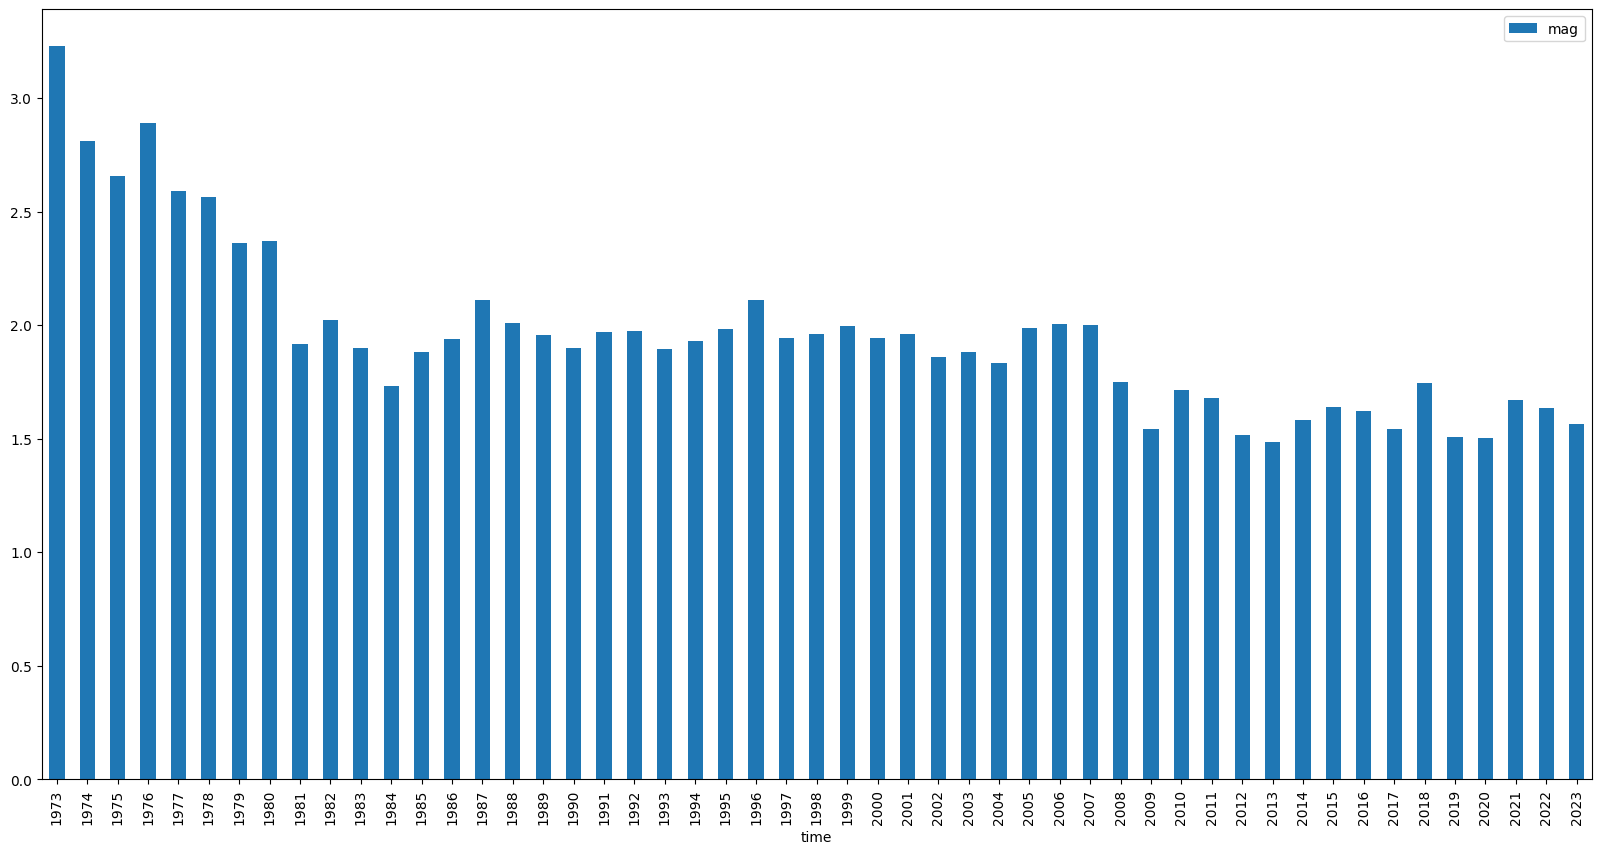

In [48]:
# get mean magnitude per year
df.groupby("time").agg({"mag": "mean"}).plot.bar(figsize=(20, 10))

<Axes: xlabel='time'>

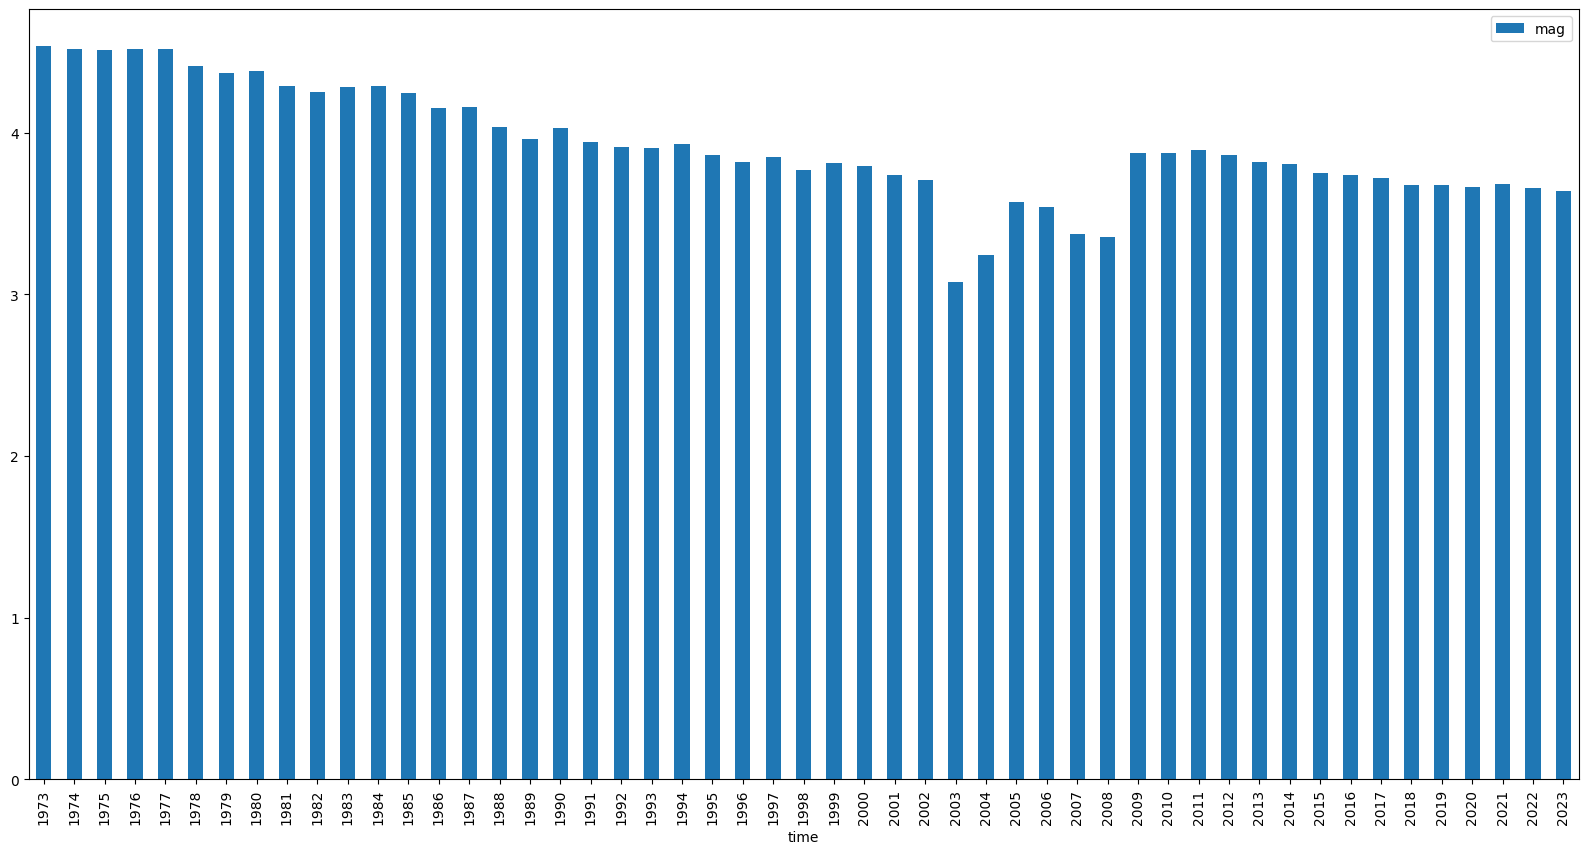

In [49]:
# get mean magnitude per region per year
df.groupby(["time", "pos"]).agg({"mag": "mean"}).reset_index().groupby("time").agg({"mag": "mean"}).plot.bar(figsize=(20, 10))

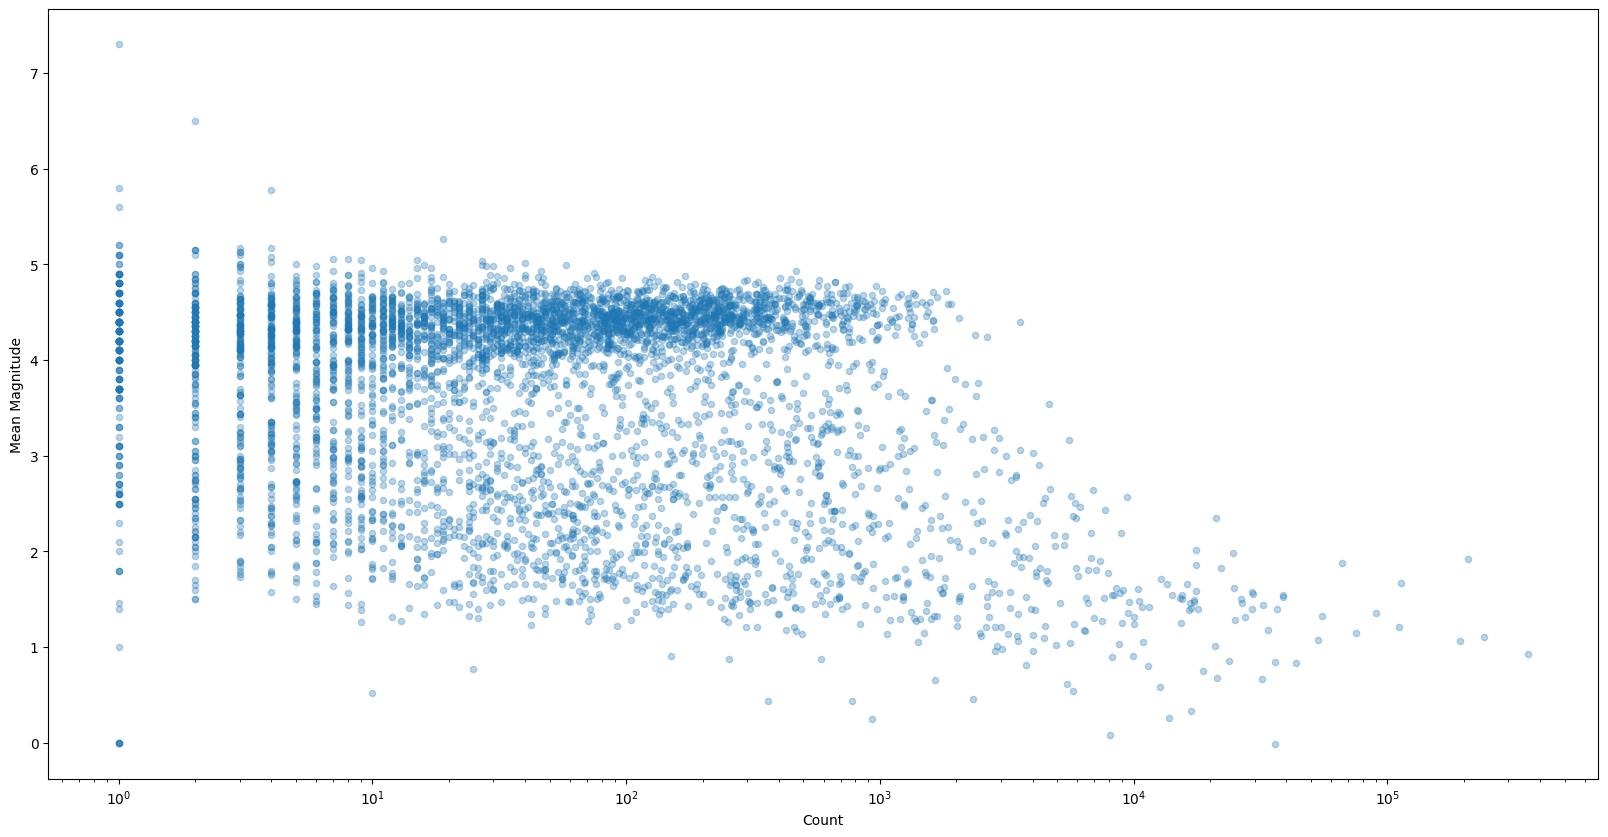

In [50]:
df.groupby(["pos"]).agg({"mag": "mean", "time": "count"}).reset_index().plot.scatter(x="time", y="mag", figsize=(20, 10), alpha=0.3)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("Mean Magnitude")
plt.show()

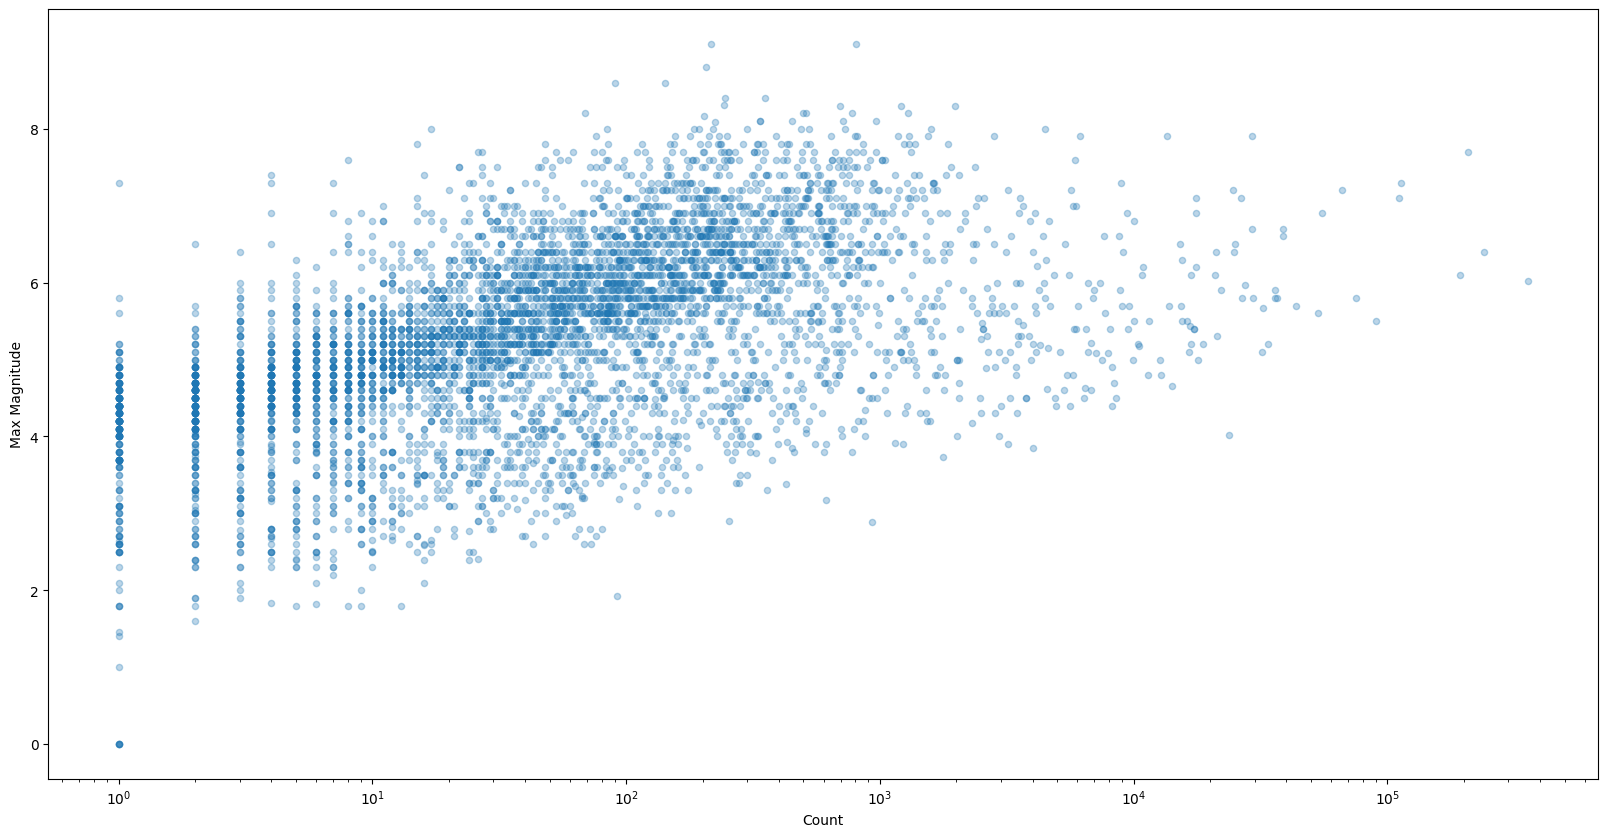

In [51]:
df.groupby(["pos"]).agg({"mag": "max", "time": "count"}).reset_index().plot.scatter(x="time", y="mag", figsize=(20, 10), alpha=0.3)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("Max Magnitude")
plt.show()

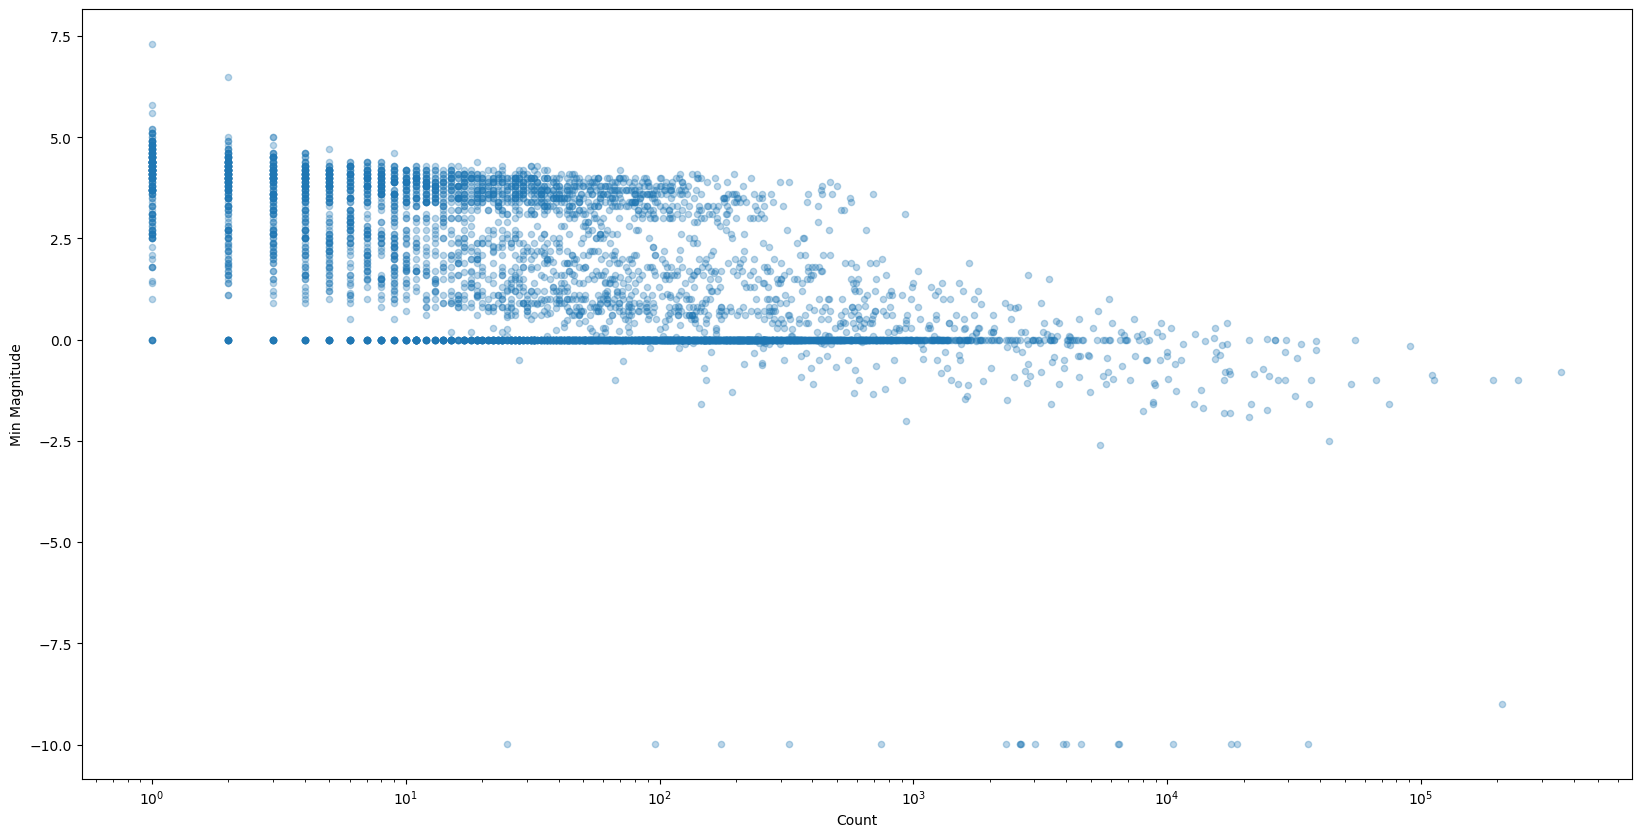

In [52]:
df.groupby(["pos"]).agg({"mag": "min", "time": "count"}).reset_index().plot.scatter(x="time", y="mag", figsize=(20, 10), alpha=0.3)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("Min Magnitude")
plt.show()

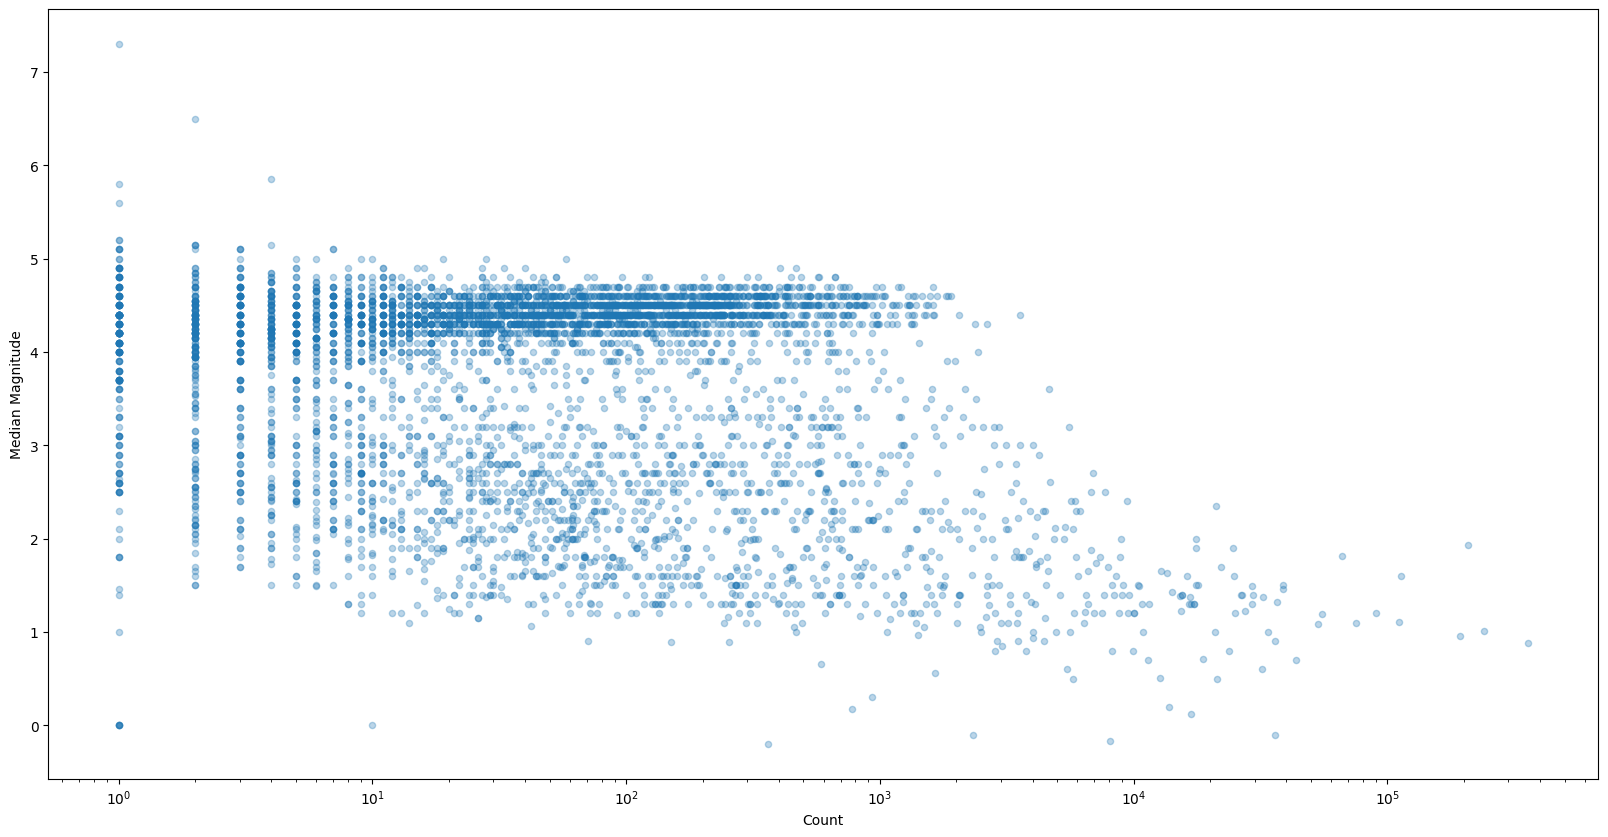

In [53]:
df.groupby(["pos"]).agg({"mag": "median", "time": "count"}).reset_index().plot.scatter(x="time", y="mag", figsize=(20, 10), alpha=0.3)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("Median Magnitude")
plt.show()